In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

# helper functions
sys.path.insert(0, "../src/lib")

import dataset as dataset_funcs
# import cleaning as cleaning_funcs

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
sales_df = pd.read_csv('../data/raw/sales.csv')
sales_df.DATE_ORDER = sales_df.DATE_ORDER.astype("datetime64")
sales_df["UNIT_PRICE"] = sales_df["REVENUE"] / sales_df["QTY_ORDER"]
sales_df.head()

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,UNIT_PRICE
0,P6,2015-08-02,1.000,1808.990,1808.990
1,P6,2015-08-17,1.000,1674.000,1674.000
2,P6,2015-08-17,1.000,1673.950,1673.950
3,P6,2015-08-11,1.000,1674.000,1674.000
4,P6,2015-08-17,1.000,1674.000,1674.000


as we mentioned on the **EXPLORATORY DATA ANALYSIS**, we will remove some bad data from our dataset to avoid propagating these errors to the model (using helper functions).

In [5]:
# sales_df = cleaning_funcs.clean_sales_dataframe(sales_df);sales_df

let's split the data into each product (because each product may have different dynamics)

In [6]:
grouped = sales_df.groupby([sales_df.PROD_ID])
(p1,p2,p3,p4,p5,p6,p7,p8,p9) = [grouped.get_group(prod_id) for prod_id in grouped.groups.keys()]

In [7]:
# let's also aggregate rows with the same timestamp

# LATER

# dataset7 = p7.groupby(p7.DATE_ORDER).agg({
#    "QTY_ORDER":np.sum,
#    "UNIT_PRICE": np.mean
#})

let's use P7 in the first run because it's the product the with the most available data

In [8]:
p7 = p7.sort_values(['DATE_ORDER'])

In [13]:
# now just select the columns we will use in this very simple model
p7 = p7[["UNIT_PRICE","QTY_ORDER"]]

In [10]:
X,y = dataset_funcs.make_Xy_simple(p7)

In [11]:
X.shape,y.shape

((27840, 1), (27840,))

For the first approach I will use a simple linear model (linear regression) with a ridge (i.e., L2) regularizer so as to avoid overfitting, since we don't have a lot of data here.

The class `RidgeCV` performs Ridge Regression and performs cross validation to select the most suitable alpha (regularization parameter).

In [62]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_absolute_error

MAE for cross validated model: 0.13449337158309696


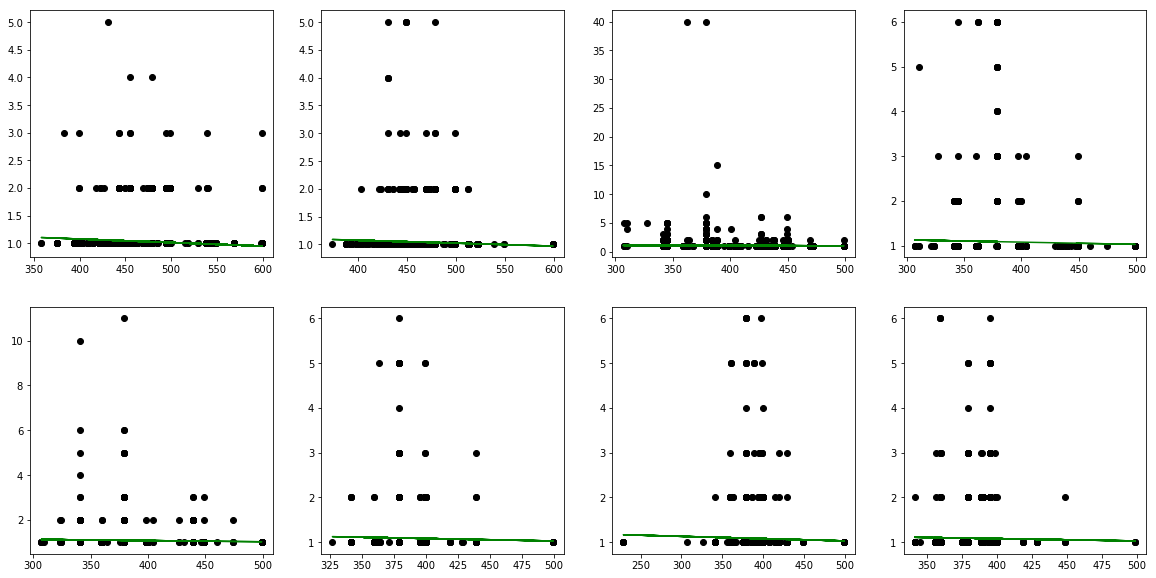

In [65]:
kf = KFold(n_splits=8)

fig, axes = plt.subplots(2, 4, figsize=(20,10))

# I think MAE (mean absolute error) is easier to interpret than MSE (mean squared error)
MAES = []

for split,(train_index, test_index) in enumerate(kf.split(X)):  
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    regr = LinearRegression()
    regr.fit(X_train,y_train)
    MAE= mean_absolute_error(y_test,regr.predict(X_test))
    MAES.append(MAE)
    axes[split // 4][split % 4].scatter(X_test, y_test, color='black')
    axes[split // 4][split % 4].plot(X_test, regr.predict(X_test), color='green')
    
final_MAE = np.array(MAES).mean()

print("MAE for cross validated model: {0}".format(final_MAE))